In [2]:
pip install tifffile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
ls -l /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images2024.08.02_U2OS_E3_RWM1852_Phalllo568_DAPI_8_1.tf8

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ls: cannot access '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images2024.08.02_U2OS_E3_RWM1852_Phalllo568_DAPI_8_1.tf8': No such file or directory


In [2]:
ls -l /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/2024.08.02_U2OS_E1_RWM817_Phalllo568_DAPI_4_1.tf8

-rwxrwx---+ 1 sivan e0zi 1639653 Aug  2 12:39 /home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/2024.08.02_U2OS_E1_RWM817_Phalllo568_DAPI_4_1.tf8*


In [3]:
import tifffile

# Load the multichannel image
file_path = "~/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_13_1.tf8"

# Replace "~" with the actual home directory
import os
file_path = os.path.expanduser(file_path)

# Load the image using tifffile
image = tifffile.imread(file_path)

# Check image shape (e.g., Z x Channels x Y x X or similar)
print(f"Image shape: {image.shape}")

# Access individual channels (assuming shape: Channels x Y x X)
channel_1 = image[0]
channel_2 = image[1] if image.shape[0] > 1 else None

# Save or process individual channels
tifffile.imwrite('channel_1.tif', channel_1)
if channel_2 is not None:
    tifffile.imwrite('channel_2.tif', channel_2)

print("Channels extracted and saved.")


Image shape: (3, 512, 512)
Channels extracted and saved.


In [26]:
from skimage.restoration import rolling_ball

/home/a/a_siva04/Cloud_Data/Wedlich-Söldner/Athul/Analysis_New/MorphoQuant/U2OS/60X/Test/Contrast/Green/LA13_E1_F2_45.tif
/home/a/a_siva04/Cloud_Data/Athul/Analysis_New/MorphoQuant/U2OS/60X/Masks and Images/Green/LA17_E1_F2/LA17_E1_F2_16.tif

In [20]:
from skimage.restoration import rolling_ball
import cv2
import numpy as np

def create_masks_with_bg_subtraction(green_image, red_image, cell_mask_path, rolling_ball_radius=25, shrink_by=10):
    """
    Function to create fiber, fiber-in-cell, and cytosol masks with background subtraction,
    and shrink the cell mask by a specified number of pixels toward the center of the mask.
    
    Args:
        green_image (np.ndarray): Green channel image.
        red_image (np.ndarray): Red channel image.
        cell_mask_path (str): Path to the cell mask.
        rolling_ball_radius (int): Radius for rolling ball background subtraction.
        shrink_by (int): Number of pixels to shrink the cell mask inward.
        
    Returns:
        tuple: (shrunken_cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask)
    """
    # Load the cell mask
    cell_mask = cv2.imread(cell_mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize cell mask if necessary
    if cell_mask.shape != red_image.shape:
        cell_mask = cv2.resize(cell_mask, (red_image.shape[1], red_image.shape[0]))

    # Ensure uint8 format for the cell mask
    cell_mask = cell_mask.astype(np.uint8)

    # Shrink the cell mask using morphological erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (shrink_by * 2 + 1, shrink_by * 2 + 1))
    shrunken_cell_mask = cv2.erode(cell_mask, kernel, iterations=1)

    # Ensure the red image is 2D and single-channel
    if len(red_image.shape) > 2:
        raise ValueError(f"Expected a 2D single-channel image for red_image, got shape: {red_image.shape}")

    # Convert red_image to 8-bit if not already
    if red_image.dtype != np.uint8:
        red_image_scaled = cv2.normalize(red_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        red_image_scaled = red_image

    # Perform background subtraction using rolling ball
    background = rolling_ball(red_image_scaled, radius=rolling_ball_radius)
    red_image_bg_subtracted = red_image_scaled - background

    # Ensure the result is within valid range
    red_image_bg_subtracted = np.clip(red_image_bg_subtracted, 0, 255).astype(np.uint8)

    # Segment fibers (Red Channel) using OTSU thresholding
    _, fiber_mask = cv2.threshold(red_image_bg_subtracted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the shrunken cell mask to fiber segmentation
    fiber_mask_in_cell = cv2.bitwise_and(fiber_mask, shrunken_cell_mask)

    # Create cytosol segmentation
    cytosol_mask = cv2.bitwise_and(shrunken_cell_mask, 255 - fiber_mask)

    return shrunken_cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask


Fiber Mean Intensity: 3116.351251351127
Cytosol Mean Intensity: 2205.1273216874956
Whole Cell Mean Intensity: 2618.5294417201058
Fiber Standard Deviation: 870.9578675347958
Cytosol Standard Deviation: 530.8620507872228
Whole Cell Standard Deviation: 838.9919122832342


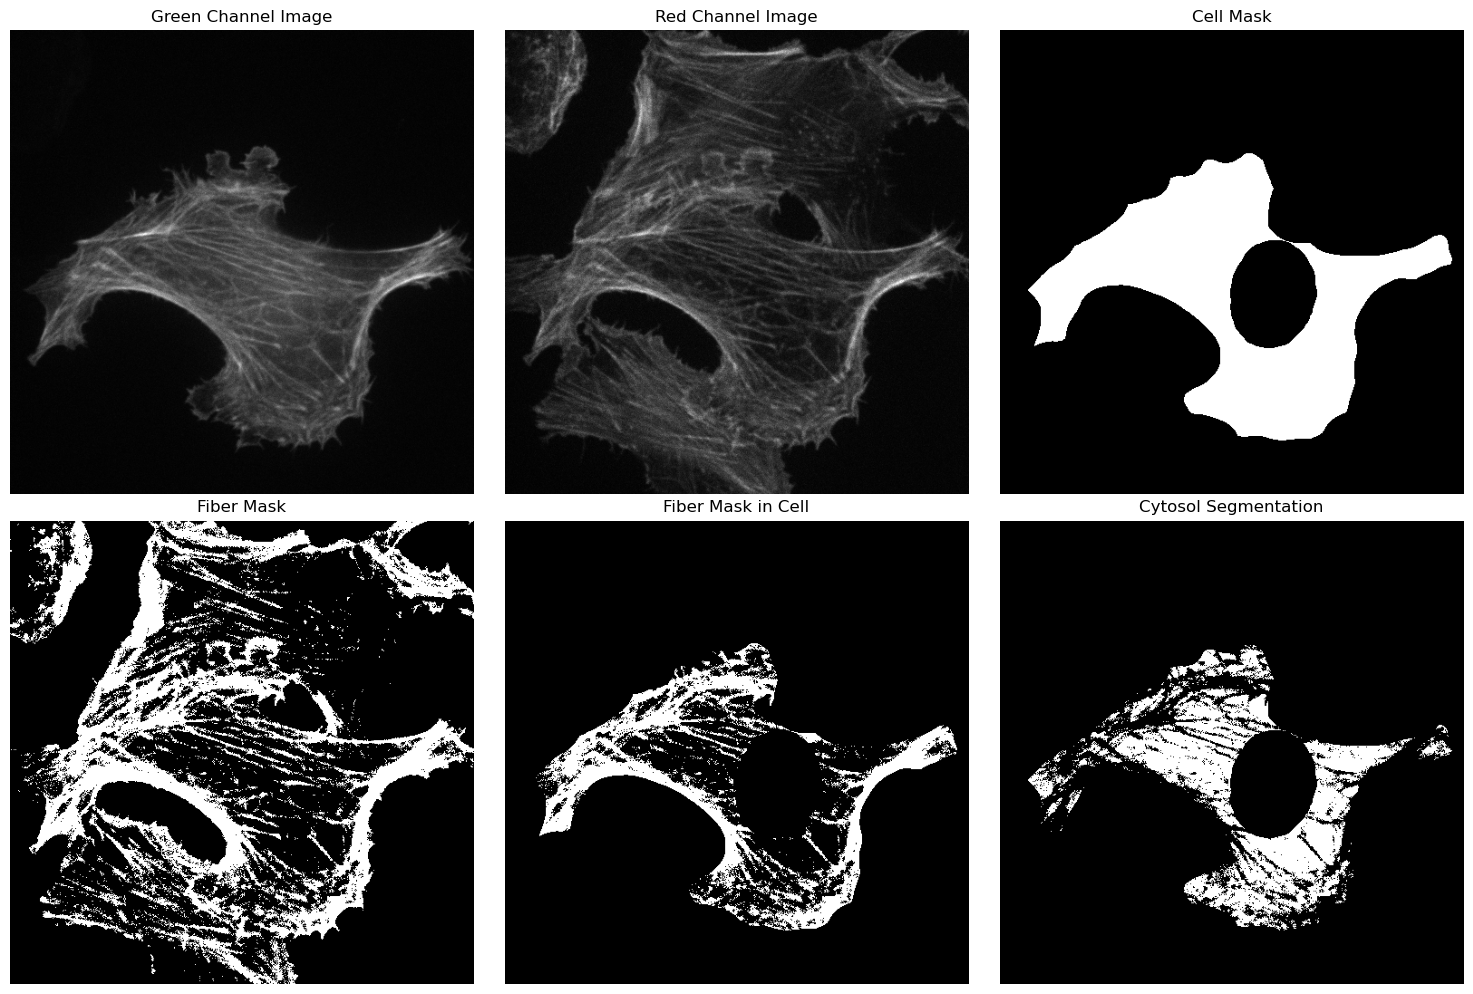

'/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/segmentation_results.svg'

In [28]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# File paths
composite_image_path = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/2024.08.02_U2OS_E3_RWM1852_Phalllo568_DAPI_8_1.tf8'
cell_mask_path = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Final_Masks/2024.08.02_U2OS_E3_RWM1852_Phalllo568_DAPI_8_1_L2_1.tiff'

# Load the multichannel composite image
image = tifffile.imread(composite_image_path)

# Extract the green and red channels
green_image = image[1, :, :]  # Second channel (Green)
red_image = image[2, :, :]    # Third channel (Red)

# Load the cell mask
cell_mask = cv2.imread(cell_mask_path, cv2.IMREAD_GRAYSCALE)

# # Resize cell mask if necessary
# if cell_mask.shape != red_image.shape:
#     cell_mask = cv2.resize(cell_mask, (red_image.shape[1], red_image.shape[0]))

# # Ensure both are uint8
# cell_mask = cell_mask.astype(np.uint8)


# # Segment fibers (Red Channel) using OTSU thresholding
# _, fiber_mask = cv2.threshold(red_image, 0, 255,  cv2.THRESH_OTSU)
# fiber_mask = fiber_mask.astype(np.uint8)

# # Apply cell mask to fiber segmentation
# fiber_mask_in_cell = cv2.bitwise_and(fiber_mask, cell_mask)

# # Create cytosol segmentation
# cytosol_mask = cv2.bitwise_and(cell_mask, 255 - fiber_mask)
cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask =  create_masks_with_bg_subtraction(green_image, red_image, cell_mask_path, rolling_ball_radius=25, shrink_by=10)
# Measure intensity and standard deviation in green channel image
fiber_intensity = green_image[fiber_mask_in_cell > 0]
cytosol_intensity = green_image[cytosol_mask > 0]
whole_cell_intensity = green_image[cell_mask > 0]  # Entire cell mask

fiber_mean_intensity = np.mean(fiber_intensity)
cytosol_mean_intensity = np.mean(cytosol_intensity)
whole_cell_mean_intensity = np.mean(whole_cell_intensity)

fiber_std_deviation = np.std(fiber_intensity)
cytosol_std_deviation = np.std(cytosol_intensity)
whole_cell_std_deviation = np.std(whole_cell_intensity)

# Print intensities and standard deviations
print("Fiber Mean Intensity:", fiber_mean_intensity)
print("Cytosol Mean Intensity:", cytosol_mean_intensity)
print("Whole Cell Mean Intensity:", whole_cell_mean_intensity)
print("Fiber Standard Deviation:", fiber_std_deviation)
print("Cytosol Standard Deviation:", cytosol_std_deviation)
print("Whole Cell Standard Deviation:", whole_cell_std_deviation)

# Visualization of results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(green_image, cmap='gray')
plt.title('Green Channel Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(red_image, cmap='gray')
plt.title('Red Channel Image')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cell_mask, cmap='gray')
plt.title('Cell Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(fiber_mask, cmap='gray')
plt.title('Fiber Mask')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fiber_mask_in_cell, cmap='gray')
plt.title('Fiber Mask in Cell')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(cytosol_mask, cmap='gray')
plt.title('Cytosol Segmentation')
plt.axis('off')

plt.tight_layout()

# Save the plots
plot_save_path = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/segmentation_results.svg'
plt.savefig(plot_save_path)
plt.show()

plot_save_path


In [27]:
cell_mask_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Final_Masks/'
composite_image_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/'
output_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output'

In [2]:
import os
import cv2
import numpy as np
import tifffile
import pandas as pd
from skimage.restoration import rolling_ball
import pandas as pd


In [9]:
from skimage.restoration import rolling_ball
import cv2
import numpy as np

def create_masks_with_bg_subtraction(green_image, red_image, cell_mask_path, rolling_ball_radius, shrink_by):
    """
    Function to create fiber, fiber-in-cell, and cytosol masks with background subtraction,
    and shrink the cell mask by a specified number of pixels toward the center of the mask.
    
    Args:
        green_image (np.ndarray): Green channel image.
        red_image (np.ndarray): Red channel image.
        cell_mask_path (str): Path to the cell mask.
        rolling_ball_radius (int): Radius for rolling ball background subtraction.
        shrink_by (int): Number of pixels to shrink the cell mask inward.
        
    Returns:
        tuple: (shrunken_cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask)
    """
    # Load the cell mask
    cell_mask = cv2.imread(cell_mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize cell mask if necessary
    if cell_mask.shape != red_image.shape:
        cell_mask = cv2.resize(cell_mask, (red_image.shape[1], red_image.shape[0]))

    # Ensure uint8 format for the cell mask
    cell_mask = cell_mask.astype(np.uint8)

    # Shrink the cell mask using morphological erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (shrink_by * 2 + 1, shrink_by * 2 + 1))
    shrunken_cell_mask = cv2.erode(cell_mask, kernel, iterations=1)

    # Ensure the red image is 2D and single-channel
    if len(red_image.shape) > 2:
        raise ValueError(f"Expected a 2D single-channel image for red_image, got shape: {red_image.shape}")

    # Convert red_image to 8-bit if not already
    if red_image.dtype != np.uint8:
        red_image_scaled = cv2.normalize(red_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        red_image_scaled = red_image

    # Perform background subtraction using rolling ball
    background = rolling_ball(red_image_scaled, radius=rolling_ball_radius)
    red_image_bg_subtracted = red_image_scaled - background

    # Ensure the result is within valid range
    red_image_bg_subtracted = np.clip(red_image_bg_subtracted, 0, 255).astype(np.uint8)

    # Segment fibers (Red Channel) using OTSU thresholding
    _, fiber_mask = cv2.threshold(red_image_bg_subtracted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the shrunken cell mask to fiber segmentation
    fiber_mask_in_cell = cv2.bitwise_and(fiber_mask, shrunken_cell_mask)

    # Create cytosol segmentation
    cytosol_mask = cv2.bitwise_and(shrunken_cell_mask, 255 - fiber_mask)

    return shrunken_cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask


In [15]:
def process_images(cell_mask_dir, composite_image_dir, output_dir):
    """
    Process all cell masks and their corresponding composite images.
    """
    # Get list of cell mask files
    cell_mask_files = [f for f in os.listdir(cell_mask_dir) if f.endswith(".tiff")]

    # Prepare data for green and red channels
    green_measurements = []
    red_measurements = []

    for cell_mask_file in cell_mask_files:
        try:
            # Extract the base name without the suffix (_L2_X.tiff)
            base_name = "_".join(cell_mask_file.split("_")[:-2])

            # Construct corresponding composite image file name
            composite_image_file = f"{base_name}.tf8"
            composite_image_path = os.path.join(composite_image_dir, composite_image_file)

            # Check if composite image exists
            if not os.path.exists(composite_image_path):
                print(f"Composite image not found for cell mask: {cell_mask_file}")
                continue

            # Load the composite image
            image = tifffile.imread(composite_image_path)

            # Ensure the composite image has at least 3 channels
            if len(image.shape) < 3 or image.shape[0] < 3:
                print(f"Skipping file due to insufficient channels: {composite_image_file}")
                continue

            # Extract green and red channels
            green_image = image[1, :, :]  # Second channel (Green)
            red_image = image[2, :, :]    # Third channel (Red)

            # Load cell mask and generate masks
            cell_mask_path = os.path.join(cell_mask_dir, cell_mask_file)
            
            # cell_mask, fiber_mask, fiber_mask_in_cell, cytosol_mask = create_masks_with_bg_subtraction(
            #     green_image, red_image, cell_mask_path,rolling_ball_radius=50
            # )
            cell_mask, red_image_bg_subtracted, fiber_mask, fiber_mask_in_cell, cytosol_mask = create_masks_with_bg_subtraction(green_image, red_image, cell_mask_path, rolling_ball_radius=10, shrink_by=10)
            # Save the masks
            save_masks(output_dir, cell_mask_file, fiber_mask, fiber_mask_in_cell, cytosol_mask)

            # Calculate measurements for green channel
            green_data = calculate_measurements(green_image, cell_mask, fiber_mask_in_cell, cytosol_mask, cell_mask_file)
            green_measurements.append(green_data)

            # Calculate measurements for red channel
            red_data = calculate_measurements(red_image, cell_mask, fiber_mask_in_cell, cytosol_mask, cell_mask_file)
            red_measurements.append(red_data)

        except Exception as e:
            # Log the error and skip the problematic file
            print(f"Error processing {cell_mask_file}: {e}")
            continue

    # Save measurements to CSV
    save_measurements_to_csv(output_dir, green_measurements, "Green")
    save_measurements_to_csv(output_dir, red_measurements, "Red")


In [16]:

def calculate_measurements(channel_image, cell_mask, fiber_mask_in_cell, cytosol_mask, cell_mask_file):
    """
    Function to calculate detailed measurements for a given channel.
    """
    # Intensity and area measurements for fibers
    fiber_intensity = channel_image[fiber_mask_in_cell > 0]
    fiber_area = np.sum(fiber_mask_in_cell > 0)

    # Intensity and area measurements for cytosol
    cytosol_intensity = channel_image[cytosol_mask > 0]
    cytosol_area = np.sum(cytosol_mask > 0)

    # Intensity and area measurements for the whole cell
    whole_cell_intensity = channel_image[cell_mask > 0]
    whole_cell_area = np.sum(cell_mask > 0)

    # Calculate metrics

    measurements = {
        "Whole Cell Area": whole_cell_area,
        "Total Cell Signal": np.sum(whole_cell_intensity),
        "Mean Cell Signal": np.mean(whole_cell_intensity),
        "Median Cell Signal": np.median(whole_cell_intensity),
        "Cell Signal Standard Deviation": np.std(whole_cell_intensity),
        "Whole Fiber Area": fiber_area,
        "Total Fiber Signal": np.sum(fiber_intensity),
        "Mean Fiber Signal": np.mean(fiber_intensity),
        "Median Fiber Signal": np.median(fiber_intensity),
        "Fiber Signal Standard Deviation": np.std(fiber_intensity),
        "Whole Cytosol Area": cytosol_area,
        "Total Cytosol Signal": np.sum(cytosol_intensity),
        "Mean Cytosol Signal": np.mean(cytosol_intensity),
        "Median Cytosol Signal": np.median(cytosol_intensity),
        "Cytosol Signal Standard Deviation": np.std(cytosol_intensity),
        "Cell Mask File": os.path.basename(cell_mask_file),

        # Additional measurements
        "SNR": np.mean(fiber_intensity) / np.mean(cytosol_intensity),
        "Contrast Ratio": (np.mean(fiber_intensity) - np.mean(cytosol_intensity)) / np.std(cytosol_intensity)
    }
    return measurements

def save_masks(output_dir, cell_mask_file, fiber_mask, fiber_mask_in_cell, cytosol_mask):
    """
    Function to save masks into specified subfolders with appropriate filenames.
    """
    # Extract base name for saving
    base_name = os.path.splitext(cell_mask_file)[0]

    # Create subdirectories for masks
    fiber_dir = os.path.join(output_dir, "Fiber_Masks")
    cytosol_dir = os.path.join(output_dir, "Cytosol_Masks")

    os.makedirs(fiber_dir, exist_ok=True)
    os.makedirs(cytosol_dir, exist_ok=True)

    # Save masks
    # tifffile.imwrite(os.path.join(fiber_dir, f"{base_name}_fiber_mask.tiff"), fiber_mask)
    tifffile.imwrite(os.path.join(fiber_dir, f"{cell_mask_file}_fiber_mask.tiff"), fiber_mask_in_cell)
    tifffile.imwrite(os.path.join(cytosol_dir, f"{cell_mask_file}_cytosol_mask.tiff"), cytosol_mask)

def save_measurements_to_csv(output_dir, measurements, channel_name):
    """
    Save measurements to a CSV file in the output directory.
    """
    # Convert measurements to DataFrame
    df = pd.DataFrame(measurements)

    # Path to CSV file
    csv_file = os.path.join(output_dir, f"{channel_name}_measurements.csv")

    # Save to CSV
    df.to_csv(csv_file, index=False)



# Directories for input and output
cell_mask_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Segmentation/Final_Masks/'
composite_image_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Images/'
output_dir = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_10_shrunk_masks'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process images
process_images(cell_mask_dir, composite_image_dir, output_dir)

print("Processing complete. Measurements saved to CSV files.")


Error processing 2024.08.02_U2OS_E1_RWM1852_Phalllo568_DAPI_17_2_L2_1.tiff: Expected a 2D single-channel image for red_image, got shape: (3, 512, 512)
Processing complete. Measurements saved to CSV files.


In [20]:
# Load the newly uploaded Green and Red measurement files
green_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Green_measurements.csv'
red_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Red_measurements.csv'

# Define the list of valid constructs to extract
valid_constructs = [
    'RWM1852', 'RWM1853', 'RWM1854', 'RWM1855',
    'RWM1856', 'RWM986', 'RWM817', 'RWM317'
]

# Create a regex pattern that matches the valid constructs
construct_pattern = '|'.join(valid_constructs)

# Process the Green measurements file
green_data_new = pd.read_csv(green_file_path_new)
green_data_new['Construct'] = green_data_new['Cell Mask File'].str.extract(f'({construct_pattern})')

# Save the updated Green measurements file
corrected_green_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Corrected_Green_measurements_with_constructs.csv'
green_data_new.to_csv(corrected_green_file_path_new, index=False)

# Process the Red measurements file
red_data_new = pd.read_csv(red_file_path_new)
red_data_new['Construct'] = red_data_new['Cell Mask File'].str.extract(f'({construct_pattern})')

# Save the updated Red measurements file
corrected_red_file_path_new = '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Corrected_Red_measurements_with_constructs.csv'
red_data_new.to_csv(corrected_red_file_path_new, index=False)

corrected_green_file_path_new, corrected_red_file_path_new


('/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Corrected_Green_measurements_with_constructs.csv',
 '/home/s/sivan/Athul/Analysis_New/Tractin_Truncations/Contrast/Output/BG_subtracted_before_thresholding/Rolling_ball_50_shrunk_masks/Corrected_Red_measurements_with_constructs.csv')